## makemore: part 5

In [73]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [74]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [75]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [76]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [77]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [78]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [ ]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean across first 2 dimensions 
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten:
    
  def __call__(self, x):
    self.out = x.view(x.shape[0],-1)
    return self.out
  
  def parameters(self):
    return []


# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape # Batch size, Context Length or Sequence Length , Embedding or features or channels (N, L, C)
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1: # if output of above is spurious 1 dimension - return 2 D as before and squeeze first dimension
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [80]:
torch.manual_seed(42); # seed rng for reproducibility

In [ ]:
# Start
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  #  break # AFTER_DEBUG: would take out obviously to run full optimization

22097


In [36]:
# First Iteration

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

layers = [
  Embedding(vocab_size, n_embd), 
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  x=Xb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
   break # AFTER_DEBUG: would take out obviously to run full optimization

22097
      0/ 200000: 3.2696
  10000/ 200000: 2.0434
  20000/ 200000: 2.0182
  30000/ 200000: 2.4718
  40000/ 200000: 2.3306
  50000/ 200000: 2.5373
  60000/ 200000: 2.5108
  70000/ 200000: 2.4312
  80000/ 200000: 2.5401
  90000/ 200000: 2.2013
 100000/ 200000: 2.3370
 110000/ 200000: 1.8326
 120000/ 200000: 2.0457
 130000/ 200000: 2.5021
 140000/ 200000: 2.4701
 150000/ 200000: 2.2535
 160000/ 200000: 2.0922
 170000/ 200000: 2.3727
 180000/ 200000: 2.2352
 190000/ 200000: 2.1076


In [ ]:
# put layers in eval mode for batch norm
for layer in layers:
    layer.training=False

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

In [92]:
# Second Iteration with Sequential

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd), 
  Flatten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size)
])

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits=model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  #if i >= 1000:
  # break # AFTER_DEBUG: would take out obviously to run full optimization

22097
      0/ 200000: 3.6208
  10000/ 200000: 1.7994
  20000/ 200000: 2.9555
  30000/ 200000: 2.0936
  40000/ 200000: 2.6040
  50000/ 200000: 2.0936
  60000/ 200000: 2.1464
  70000/ 200000: 2.1844
  80000/ 200000: 2.2303
  90000/ 200000: 2.6661
 100000/ 200000: 2.1709
 110000/ 200000: 2.0622
 120000/ 200000: 2.3344
 130000/ 200000: 2.3886
 140000/ 200000: 2.2387
 150000/ 200000: 2.0643
 160000/ 200000: 2.1409
 170000/ 200000: 1.9995
 180000/ 200000: 2.1895
 190000/ 200000: 2.5980


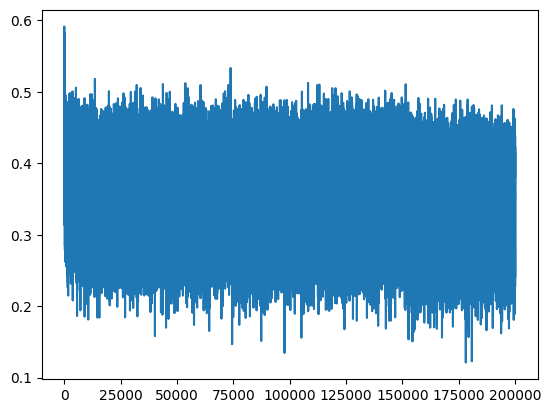

In [93]:
plt.plot(lossi) # 32 mini batch so loss keeps changing

In [94]:
torch.arange(10).view(2, 5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [95]:
torch.arange(10).view(2, -1)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [96]:
torch.tensor(lossi).view(-1, 1000).shape

torch.Size([200, 1000])

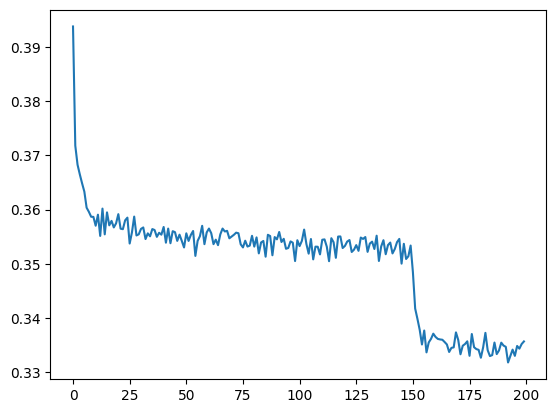

In [97]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) # mean along the row
# learning rate decay allows to settle to local minima

In [99]:
emb = C[Xtr]

In [100]:
x = emb.view(emb.shape[0], -1)
x.shape

torch.Size([182625, 80])

In [ ]:
# put layers in eval mode for batch norm
for layer in model.layers:
   layer.training = False

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.145183801651001
val 2.156336784362793


In [102]:
# sample from the model


for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # # forward pass the neural net
      # emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      # x = emb.view(emb.shape[0], -1) # concatenate the vectors
      # for layer in layers:
      #   x = layer(x)
      # logits = x
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

maryus.
amarieh.
emen.
wustah.
ismi.
mayon.
miai.
codana.
caserna.
vielah.
mashi.
lynsee.
arwina.
meker.
arshah.
eowima.
rrellie.
adryla.
maralyx.
izaley.


In [ ]:
# Wavenet - fuse tree like hierarchial - dilated causal convolution layers -> bi gram to 4 grams and so on - diffuse 2 chars, 2 bigrams and so on 
# Simple example
ix = torch.randint(0, Xtr.shape[0],(4,))
Xb, Yb = Xtr[ix], Ytr[ix] # pick 1 example
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0, 10, 15, 12,  9, 19, 19,  1],
        [ 0,  0,  0,  0,  0, 19,  8,  9],
        [ 0,  0,  0, 18, 15, 19,  5,  1],
        [ 0,  0, 15, 18,  9,  1, 14,  1]])

In [108]:
model.layers[0].out.shape # embedding layer

torch.Size([4, 8, 10])

In [109]:
model.layers[1].out.shape # flatten layer

torch.Size([4, 80])

In [110]:
model.layers[2].out.shape # linear layer

torch.Size([4, 200])

In [112]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape # linear layer internals - matrix multiplication works on last layer

torch.Size([4, 200])

In [ ]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape # 2 characters come in with 4 groups
# (1 2) (3 4) (5 6) (7 8)

In [119]:
# change flatten layer accordingly
e = torch.randn(4, 8, 10)
print(e.view(4,-1).shape)
print(e[:,::2,:].shape) # even
print(e[:,1::2,:].shape) # odd

torch.Size([4, 80])
torch.Size([4, 4, 10])
torch.Size([4, 4, 10])


In [122]:
torch.cat((e[:,::2,:],e[:,1::2,:]),dim=2).shape # along second dimension

torch.Size([4, 4, 20])

In [125]:
e.view(4,-1,20).shape

torch.Size([4, 4, 20])

In [ ]:
(torch.randn(4,5,6, 80) @ torch.randn(80, 200) + torch.randn(200)).shape


torch.Size([4, 5, 6, 200])

In [127]:
block_size

8

In [137]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd), 
  FlattenConsecutive(2),  Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),  Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size)
])

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits=model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

22397
      0/ 200000: 3.5486
  10000/ 200000: 2.4072
  20000/ 200000: 2.2263
  30000/ 200000: 2.3522
  40000/ 200000: 2.1134
  50000/ 200000: 1.9690
  60000/ 200000: 2.0725
  70000/ 200000: 1.9849
  80000/ 200000: 1.8823
  90000/ 200000: 1.9707
 100000/ 200000: 2.1380
 110000/ 200000: 2.3311
 120000/ 200000: 2.0338
 130000/ 200000: 1.9730
 140000/ 200000: 1.8219
 150000/ 200000: 2.0273
 160000/ 200000: 1.8986
 170000/ 200000: 2.1506
 180000/ 200000: 1.5890
 190000/ 200000: 2.2457


In [136]:
ix = torch.randint(0, Xtr.shape[0],(4,))
Xb, Yb = Xtr[ix], Ytr[ix] # pick 1 example
logits = model(Xb)
print(Xb.shape)
logits.shape

torch.Size([4, 8])


torch.Size([4, 27])

In [133]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 200)
BatchNorm1d : (32, 4, 200)
Tanh : (32, 4, 200)
FlattenConsecutive : (32, 2, 400)
Linear : (32, 2, 200)
BatchNorm1d : (32, 2, 200)
Tanh : (32, 2, 200)
FlattenConsecutive : (32, 400)
Linear : (32, 200)
BatchNorm1d : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


In [138]:
# put layers in eval mode for batch norm
for layer in model.layers:
   layer.training = False

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9796578884124756
val 2.0493876934051514


In [146]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits=model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

76579
      0/ 200000: 3.2649
  10000/ 200000: 2.6236
  20000/ 200000: 2.4142
  30000/ 200000: 2.2679
  40000/ 200000: 2.6319
  50000/ 200000: 2.1277
  60000/ 200000: 1.7275
  70000/ 200000: 1.7252
  80000/ 200000: 1.9307
  90000/ 200000: 2.0012
 100000/ 200000: 1.7031
 110000/ 200000: 1.6870
 120000/ 200000: 1.9965
 130000/ 200000: 1.9532
 140000/ 200000: 2.2655
 150000/ 200000: 2.1433
 160000/ 200000: 1.5722
 170000/ 200000: 1.9633
 180000/ 200000: 1.8639
 190000/ 200000: 1.9613


In [147]:
# put layers in eval mode for batch norm
for layer in model.layers:
   layer.training = False

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.866294503211975
val 2.003284454345703


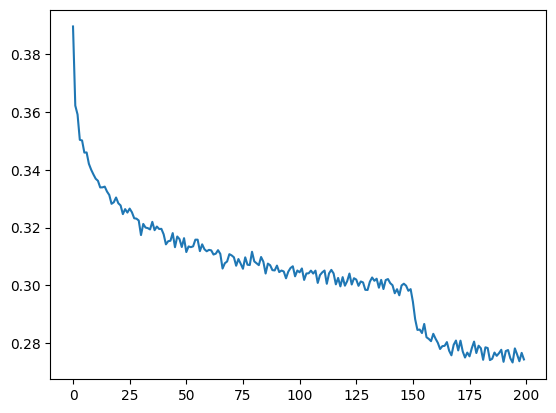

In [148]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [139]:
# Batch Norm Bug as dimensionality of input increased to 3
e = torch.randn(32,4,68)
emean = e.mean(0, keepdim=True) # 1,4,68
evar = e.var(0, keepdim=True) # 1,4,68
ehat = (e - emean) /  torch.sqrt(evar+1e-5) # 32,4,68
ehat.shape

torch.Size([32, 4, 68])

In [ ]:
emean = e.mean((0,1), keepdim=True) # 1,1,68
evar = e.var((0,1), keepdim=True) # 1,1,68
ehat = (e - emean) /  torch.sqrt(evar+1e-5) # 32,4,68
ehat.shape

torch.Size([32, 4, 68])

In [143]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [14]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.


### Next time:
Why convolutions? Brief preview/hint

In [15]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [ ]:
# forward a single example:
logits = model(Xtr[[7]]) # SHAPE 1,8 so get extra batch dimension
logits.shape

torch.Size([1, 27])

In [17]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [18]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space